In [131]:
pip install "numpy>=1.16,<2.0"

Note: you may need to restart the kernel to use updated packages.


In [132]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import json
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import KFold
import numpy as np

In [133]:
df = pd.read_csv("../conso_data.csv")

In [134]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist() # Convert object to category
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [135]:
X = df.drop(columns="pitd")
y = df['pitd']

In [136]:
num_variables = X.columns[X.dtypes == 'float64'].tolist()
cat_variables = X.columns[X.dtypes == 'category'].tolist()

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**VERY SIMPLE MODEL TRAINING NO PARAMETER TUNING**

In [138]:
model = CatBoostRegressor(
    iterations=500, 
    learning_rate=0.1, 
    depth=6, 
    cat_features=cat_variables, 
    verbose=100  # Prints training progress every 100 iterations
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 209711.6839515	test: 205474.4355425	best: 205474.4355425 (0)	total: 10.9ms	remaining: 5.43s
100:	learn: 14542.9574105	test: 18870.2051142	best: 18870.2051142 (100)	total: 477ms	remaining: 1.88s
200:	learn: 9277.2744164	test: 15842.1246941	best: 15842.1246941 (200)	total: 944ms	remaining: 1.4s
300:	learn: 6633.7594698	test: 14741.9430289	best: 14741.9430289 (300)	total: 1.41s	remaining: 930ms
400:	learn: 5122.9177602	test: 14270.3100456	best: 14266.0042111 (399)	total: 1.85s	remaining: 457ms
499:	learn: 4116.3317699	test: 13965.5157023	best: 13965.5157023 (499)	total: 2.31s	remaining: 0us

bestTest = 13965.5157
bestIteration = 499



In [139]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 195035594.0592863


**STANDARD SCALING AND K-FOLD**

In [140]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_variables),
        ('cat', 'passthrough', cat_variables)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
columns = num_variables + cat_variables

X_train_processed = pd.DataFrame(X_train_transformed, columns=columns)
X_test_processed = pd.DataFrame(X_test_transformed, columns=columns)

In [141]:
best_iterations = 1920
best_learning_rate = 0.1
best_depth = 4
best_l2 = 2.2
best_border_count = 128

model = CatBoostRegressor(
    iterations=best_iterations,
    learning_rate=best_learning_rate,
    depth=best_depth,
    l2_leaf_reg=best_l2,
    border_count=best_border_count,
    cat_features=cat_variables,  # Let CatBoost know which features are categorical
    verbose=100
)

model.fit(
    X_train_processed, y_train, 
    eval_set=(X_test_processed, y_test),
    early_stopping_rounds=50
)

0:	learn: 211474.8808200	test: 207313.1783449	best: 207313.1783449 (0)	total: 5.89ms	remaining: 11.3s
100:	learn: 17062.4796323	test: 18560.9317481	best: 18560.9317481 (100)	total: 488ms	remaining: 8.79s
200:	learn: 11220.2534817	test: 14514.6141464	best: 14514.6141464 (200)	total: 1.05s	remaining: 9.01s
300:	learn: 8855.2115039	test: 13032.4552979	best: 13032.4552979 (300)	total: 1.46s	remaining: 7.84s
400:	learn: 7299.9397090	test: 12153.2953456	best: 12153.2953456 (400)	total: 1.69s	remaining: 6.41s
500:	learn: 6211.3271740	test: 11566.7693968	best: 11566.7693968 (500)	total: 1.92s	remaining: 5.43s
600:	learn: 5412.8891934	test: 11192.3066829	best: 11192.2683788 (598)	total: 2.13s	remaining: 4.68s
700:	learn: 4777.3054729	test: 10864.5909144	best: 10864.5909144 (700)	total: 2.36s	remaining: 4.1s
800:	learn: 4301.8656118	test: 10656.2987211	best: 10654.6713729 (799)	total: 2.58s	remaining: 3.6s
900:	learn: 3872.6528189	test: 10453.9324801	best: 10453.9324801 (900)	total: 2.81s	remain

In [142]:
'''param_grid = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 10],
    'border_count': [32, 64, 128]
}
param_list = list(ParameterSampler(param_grid, n_iter=50, random_state=42))

# Set up 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for i, params in enumerate(param_list):
    print(f"Trial {i+1}/{len(param_list)}: Testing parameters {params}")
    fold_scores = []
    
    # Run cross validation manually
    for train_index, val_index in kf.split(X_train_processed):
        X_fold_train = X_train_processed.iloc[train_index]
        X_fold_val = X_train_processed.iloc[val_index]
        y_fold_train = y_train.iloc[train_index]
        y_fold_val = y_train.iloc[val_index]
        
        model = CatBoostRegressor(
            **params,
            cat_features=cat_variables,
            verbose=0
        )
        model.fit(X_fold_train, y_fold_train, 
                  eval_set=(X_fold_val, y_fold_val),
                  early_stopping_rounds=50)
        y_pred = model.predict(X_fold_val)
        fold_mse = mean_squared_error(y_fold_val, y_pred)
        fold_scores.append(fold_mse)
    
    avg_mse = np.mean(fold_scores)
    result = {"params": params, "avg_mse": avg_mse, "fold_scores": fold_scores}
    results.append(result)
    
    # Append the result to a log file in JSON format
    with open("random_search_log.txt", "a") as log_file:
        log_file.write(json.dumps(result) + "\n")
    
    print(f"Trial {i+1} complete: Average MSE = {avg_mse:.4f}")

# Optionally, save the complete results after all trials
with open("random_search_results.json", "w") as f:
    json.dump(results, f, indent=2)'''

'param_grid = {\n    \'iterations\': [500, 1000, 2000],\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'depth\': [4, 6, 8, 10],\n    \'l2_leaf_reg\': [1, 3, 5, 10],\n    \'border_count\': [32, 64, 128]\n}\nparam_list = list(ParameterSampler(param_grid, n_iter=50, random_state=42))\n\n# Set up 5-fold cross validation\nkf = KFold(n_splits=5, shuffle=True, random_state=42)\nresults = []\n\nfor i, params in enumerate(param_list):\n    print(f"Trial {i+1}/{len(param_list)}: Testing parameters {params}")\n    fold_scores = []\n    \n    # Run cross validation manually\n    for train_index, val_index in kf.split(X_train_processed):\n        X_fold_train = X_train_processed.iloc[train_index]\n        X_fold_val = X_train_processed.iloc[val_index]\n        y_fold_train = y_train.iloc[train_index]\n        y_fold_val = y_train.iloc[val_index]\n        \n        model = CatBoostRegressor(\n            **params,\n            cat_features=cat_variables,\n            verbose=0\n        )\n   

In [143]:
'''original_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 4,
    'l2_leaf_reg': 1,
    'border_count': 128
}

new_params = {
    'iterations': 1920,
    'learning_rate': 0.1,
    'depth': 4,
    'l2_leaf_reg': 2.2,
    'border_count': 128
}

np2 = {'iterations': 2000, 'learning_rate': 0.05626769709950332, 'depth': 4, 'l2_leaf_reg': 6.235587315620499, 'border_count': 234}
#np3 = {'iterations': 1500, 'learning_rate': 0.28783571318083007, 'depth': 3, 'l2_leaf_reg': 1.5944034968564198, 'border_count': 121}

def evaluate_params(params, X, y, cat_features, n_splits=5):
    """Evaluate given parameters using n-fold cross validation and return average MSE."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_list = []
    
    for train_index, val_index in kf.split(X):
        X_train_cv = X.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        X_val_cv = X.iloc[val_index]
        y_val_cv = y.iloc[val_index]
        
        model = CatBoostRegressor(
            **params,
            cat_features=cat_features,
            verbose=0
        )
        
        # Train model with early stopping
        model.fit(X_train_cv, y_train_cv, 
                  eval_set=(X_val_cv, y_val_cv), 
                  early_stopping_rounds=50)
        
        y_pred = model.predict(X_val_cv)
        mse = mean_squared_error(y_val_cv, y_pred)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Evaluate the original parameter set
avg_mse_original = evaluate_params(np2, X_train_processed, y_train, cat_variables)
print("Average MSE with original parameters:", avg_mse_original)

# Evaluate the new parameter set
#avg_mse_new = evaluate_params(np3, X_train_processed, y_train, cat_variables)
#print("Average MSE with new parameters:", avg_mse_new)'''

'original_params = {\n    \'iterations\': 1000,\n    \'learning_rate\': 0.1,\n    \'depth\': 4,\n    \'l2_leaf_reg\': 1,\n    \'border_count\': 128\n}\n\nnew_params = {\n    \'iterations\': 1920,\n    \'learning_rate\': 0.1,\n    \'depth\': 4,\n    \'l2_leaf_reg\': 2.2,\n    \'border_count\': 128\n}\n\nnp2 = {\'iterations\': 2000, \'learning_rate\': 0.05626769709950332, \'depth\': 4, \'l2_leaf_reg\': 6.235587315620499, \'border_count\': 234}\n#np3 = {\'iterations\': 1500, \'learning_rate\': 0.28783571318083007, \'depth\': 3, \'l2_leaf_reg\': 1.5944034968564198, \'border_count\': 121}\n\ndef evaluate_params(params, X, y, cat_features, n_splits=5):\n    """Evaluate given parameters using n-fold cross validation and return average MSE."""\n    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n    mse_list = []\n    \n    for train_index, val_index in kf.split(X):\n        X_train_cv = X.iloc[train_index]\n        y_train_cv = y.iloc[train_index]\n        X_val_cv = X.iloc[val_

**TESTING WITH HAS_TIME**

In [144]:
train_pool = Pool(
    data=X_train_processed, 
    label=y_train, 
    cat_features=cat_variables,  # This can be column names or indices
)

eval_pool = Pool(
    data=X_test_processed, 
    label=y_test, 
    cat_features=cat_variables, 
)

In [145]:
best_iterations = 1920
best_learning_rate = 0.1
best_depth = 4
best_l2 = 2.2
best_border_count = 128

model = CatBoostRegressor(
    iterations=best_iterations,
    learning_rate=best_learning_rate,
    depth=best_depth,
    l2_leaf_reg=best_l2,
    border_count=best_border_count,
    cat_features=cat_variables,  # Let CatBoost know which features are categorical
    verbose=100,
    has_time=False
)

model.fit(
    X_train_processed, y_train, 
    eval_set=(X_test_processed, y_test),
    early_stopping_rounds=50
)

0:	learn: 211474.8808200	test: 207313.1783449	best: 207313.1783449 (0)	total: 4.71ms	remaining: 9.03s
100:	learn: 17062.4796323	test: 18560.9317481	best: 18560.9317481 (100)	total: 297ms	remaining: 5.36s
200:	learn: 11220.2534817	test: 14514.6141464	best: 14514.6141464 (200)	total: 559ms	remaining: 4.78s
300:	learn: 8855.2115039	test: 13032.4552979	best: 13032.4552979 (300)	total: 893ms	remaining: 4.8s
400:	learn: 7299.9397090	test: 12153.2953456	best: 12153.2953456 (400)	total: 1.69s	remaining: 6.41s
500:	learn: 6211.3271740	test: 11566.7693968	best: 11566.7693968 (500)	total: 2.14s	remaining: 6.07s
600:	learn: 5412.8891934	test: 11192.3066829	best: 11192.2683788 (598)	total: 2.44s	remaining: 5.35s
700:	learn: 4777.3054729	test: 10864.5909144	best: 10864.5909144 (700)	total: 2.69s	remaining: 4.69s
800:	learn: 4301.8656118	test: 10656.2987211	best: 10654.6713729 (799)	total: 2.92s	remaining: 4.08s
900:	learn: 3872.6528189	test: 10453.9324801	best: 10453.9324801 (900)	total: 3.13s	remai

In [146]:
y_pred = model.predict(X_test_processed)
errors = np.abs(y_test - y_pred)  # Absolute error
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Absolute Error': errors
})

error_df = error_df.sort_values(by='Absolute Error', ascending=False)
print(error_df.head(10))  # Show the top 10 worst predictions

          Actual      Predicted  Absolute Error
746   914355.744  832403.392776    81952.351224
367   812555.854  768082.381750    44473.472250
1355  472023.430  506888.260780    34864.830780
383   668791.065  638108.944821    30682.120179
321   682106.173  652733.671452    29372.501548
1033  516586.695  544489.056006    27902.361006
366   970880.674  943496.128732    27384.545268
408   448479.722  475160.766770    26681.044770
76    575769.498  549217.409111    26552.088889
307   693807.967  667753.234844    26054.732156


In [147]:
y_pred.shape

(460,)

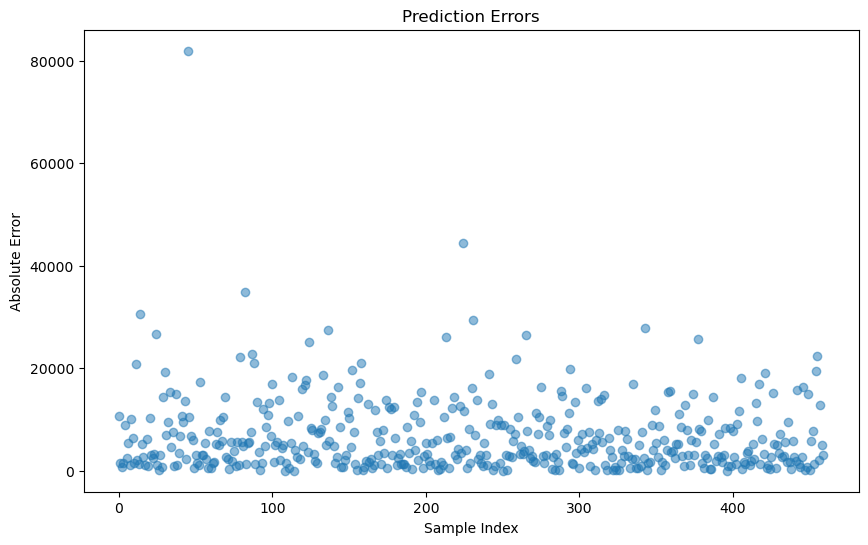

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(errors)), errors, alpha=0.5)
plt.xlabel("Sample Index")
plt.ylabel("Absolute Error")
plt.title("Prediction Errors")
plt.show()

In [149]:
error_df = X_test.copy()  # Copy test data
error_df["Actual"] = y_test
error_df["Predicted"] = model.predict(X_test_processed)
error_df["Absolute Error"] = np.abs(error_df["Actual"] - error_df["Predicted"])
worst_errors = error_df.sort_values(by="Absolute Error", ascending=False)
print(worst_errors.head(10))  # Check the top 10 worst predictions

                           date          li  li_terega  pitd_terega  \
746   2018-03-01 00:00:00+00:00   87036.283   1180.849    62536.468   
367   2017-01-27 00:00:00+00:00   51454.200   1125.431    68178.352   
1355  2019-12-07 00:00:00+00:00  124876.854   3547.783    46812.865   
383   2017-02-12 00:00:00+00:00   46514.092    991.994    53234.346   
321   2016-12-12 00:00:00+00:00   83689.902    220.485    61948.036   
1033  2019-01-01 00:00:00+00:00   94519.878   1114.266    66489.277   
366   2017-01-26 00:00:00+00:00   56982.624   1151.314    86488.850   
408   2017-03-09 00:00:00+00:00   49658.524   1041.612    38537.387   
76    2016-03-20 00:00:00+00:00   41532.670     76.813    45099.122   
307   2016-11-28 00:00:00+00:00   86112.094    248.766    58271.383   

            pitd1        pitd2        pitd7     target1    target2  \
746   1014091.163  1011554.363   787798.060    2536.800  51314.139   
367    970880.674  1001329.772   994467.543  -30449.098  46365.958   
1355   6

In [150]:
# Convert to datetime if it's not already
worst_errors["date"] = pd.to_datetime(worst_errors["date"], errors="coerce")

# Extract useful time features
worst_errors["YearMonth"] = worst_errors["date"].dt.to_period("M")  # Group by month
worst_errors["DayOfWeek"] = worst_errors["date"].dt.dayofweek  # Monday=0, Sunday=6
worst_errors["Hour"] = worst_errors["date"].dt.hour  # Extract hours

# Drop the raw timestamp to avoid issues
worst_errors = worst_errors.drop(columns=["date"], errors="ignore")

/tmp/ipykernel_6522/1356260067.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  worst_errors["YearMonth"] = worst_errors["date"].dt.to_period("M")  # Group by month


In [151]:
print(worst_errors.groupby("YearMonth")["Absolute Error"].mean())
print(worst_errors.groupby("DayOfWeek")["Absolute Error"].mean())

YearMonth
2016-01     8432.544481
2016-02     7549.834752
2016-03    14271.215073
2016-04     8769.779561
2016-05     3254.280678
               ...     
2022-04    13708.093626
2022-05     3790.191578
2022-06     4267.475863
2022-07     2305.730562
2022-08      977.440345
Freq: M, Name: Absolute Error, Length: 79, dtype: float64
DayOfWeek
0    6366.502565
1    5577.851136
2    6190.187543
3    7524.643698
4    7153.655285
5    5862.270401
6    7551.184743
Name: Absolute Error, dtype: float64


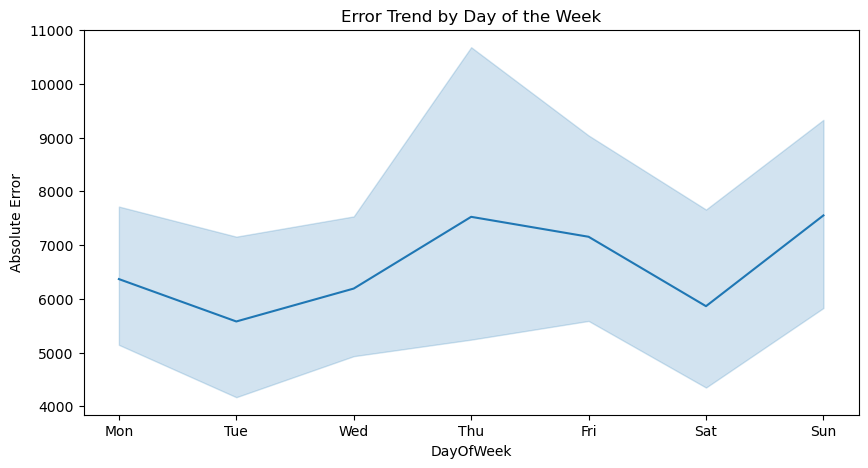

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=worst_errors, x="DayOfWeek", y="Absolute Error")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title("Error Trend by Day of the Week")
plt.show()


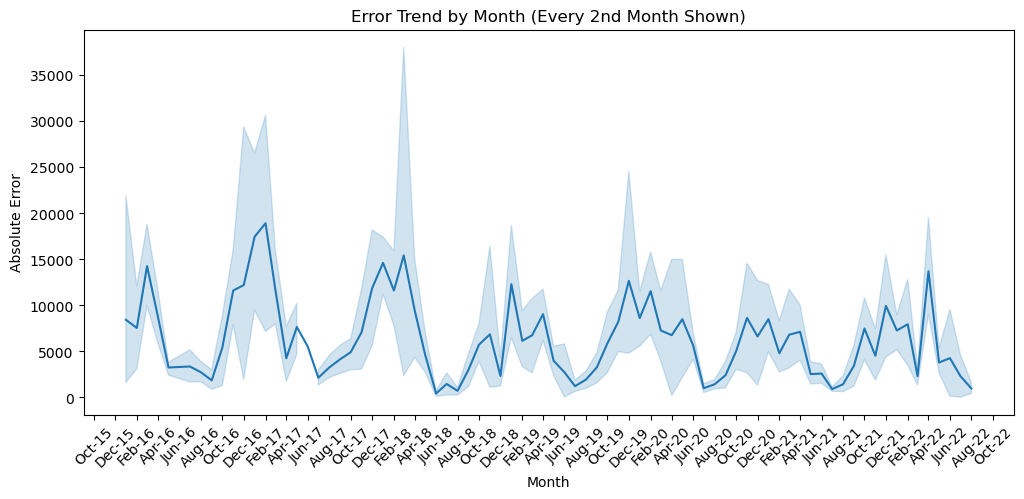

In [153]:
import matplotlib.dates as mdates

# Convert YearMonth to a proper datetime index
worst_errors["YearMonth"] = worst_errors["YearMonth"].dt.to_timestamp()

# Sort and set index
worst_errors = worst_errors.sort_values("YearMonth").set_index("YearMonth")

# Plot with YearMonth as index
plt.figure(figsize=(12, 5))
sns.lineplot(data=worst_errors, x=worst_errors.index, y="Absolute Error")

# Format x-axis to show only "MMM-YY" (e.g., Jan-24, Mar-24, etc.)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))  # Format: Jan-24
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2nd month

# Improve readability
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.title("Error Trend by Month (Every 2nd Month Shown)")
plt.show()


In [155]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))  # Show top 10 important features

ValueError: All arrays must be of the same length

In [156]:
print(len(X_train.columns), len(model.feature_importances_))


59 47
